# Movie Reviews Classification

### Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from bs4 import BeautifulSoup

import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load Data

In [2]:
df = pd.read_csv('/content/labeledTrainData.tsv', delimiter="\t")

df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


### Preprocess

In [4]:
df = df.drop(['id'], axis=1)

In [5]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [6]:
def clean_text(text):

    text = BeautifulSoup(text, "html.parser").get_text().lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = [lemmatizer.lemmatize(token, "n") for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)

    return text

In [7]:
df['clean_review'] = df.review.apply(lambda x: clean_text(x))

In [8]:
df["text_len"] = df.clean_review.apply(lambda x: len(x.split(' ')))

In [9]:
df.head()

,sentiment,review,clean_review,text_len
0,1,With all this stuff going down at the moment w...,stuff go moment mj ive start listen music watc...,224
1,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothy hines entertain film...,82
2,0,The film starts with a manager (Nicholas Bell)...,film start manager nicholas bell give welcome ...,246
3,0,It must be assumed that those who praised this...,must assume praise film greatest film opera ev...,198
4,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80 ex...,215


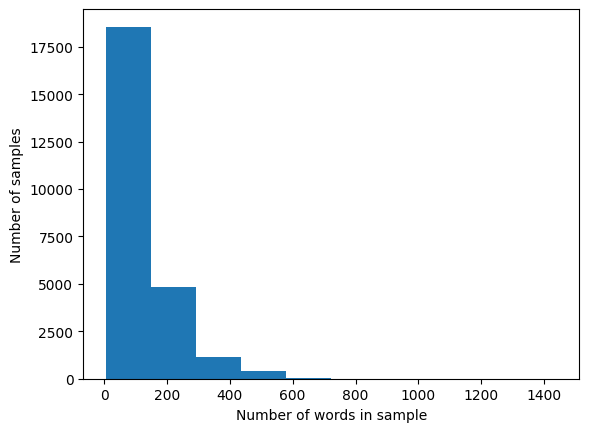

In [10]:
plt.hist(df.text_len)
plt.xlabel("Number of words in sample")
plt.ylabel("Number of samples")
plt.show()

In [11]:
max_len = df.text_len.max()
avg_len = df.text_len.mean()

print(max_len)
print(avg_len)

1440
124.506


In [12]:
max_features = 6000

tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(df['clean_review'])

list_tokenized_train = tokenizer.texts_to_sequences(df['clean_review'])

### Extract X & y

In [13]:
maxlen = 400

X = pad_sequences(list_tokenized_train, maxlen=maxlen)

y = df['sentiment']

### Train-Validation Split

In [14]:
x_train, x_val = X[:18000], X[18000:]
y_train, y_val = y[:18000], y[18000:]

### Model

In [15]:
model = Sequential()
model.add(Embedding(max_features, max_len))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 1440)        8640000   
                                                                 
 bidirectional (Bidirection  (None, None, 256)         1606656   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [17]:
# Learning rate optimizer
LR_optim = ReduceLROnPlateau(monitor='val_accuracy',
                             patience=2, # change after num of epochs
                             verbose=1,  # update messages
                             factor=0.5, # reduction on lr
                             min_lr=0.01)# limit for the decay

### Training the model

In [18]:
batch_size = 100
epochs = 10

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[LR_optim],
          validation_data=(x_val, y_val))

Epoch 1/10
180/180 [==============================] - 84s 420ms/step - loss: 0.6925 - accuracy: 0.5195 - val_loss: 0.6915 - val_accuracy: 0.5977 - lr: 1.0000e-05
Epoch 2/10
180/180 [==============================] - 69s 385ms/step - loss: 0.6890 - accuracy: 0.6066 - val_loss: 0.6841 - val_accuracy: 0.7031 - lr: 1.0000e-05
Epoch 3/10
180/180 [==============================] - 55s 306ms/step - loss: 0.6170 - accuracy: 0.7431 - val_loss: 0.4696 - val_accuracy: 0.8140 - lr: 1.0000e-05
Epoch 4/10
180/180 [==============================] - 58s 324ms/step - loss: 0.3846 - accuracy: 0.8471 - val_loss: 0.3713 - val_accuracy: 0.8416 - lr: 1.0000e-05
Epoch 5/10
180/180 [==============================] - 50s 275ms/step - loss: 0.3180 - accuracy: 0.8767 - val_loss: 0.3608 - val_accuracy: 0.8424 - lr: 1.0000e-05
Epoch 6/10
180/180 [==============================] - 53s 294ms/step - loss: 0.2846 - accuracy: 0.8930 - val_loss: 0.3371 - val_accuracy: 0.8611 - lr: 1.0000e-05
Epoch 7/10
180/180 [========

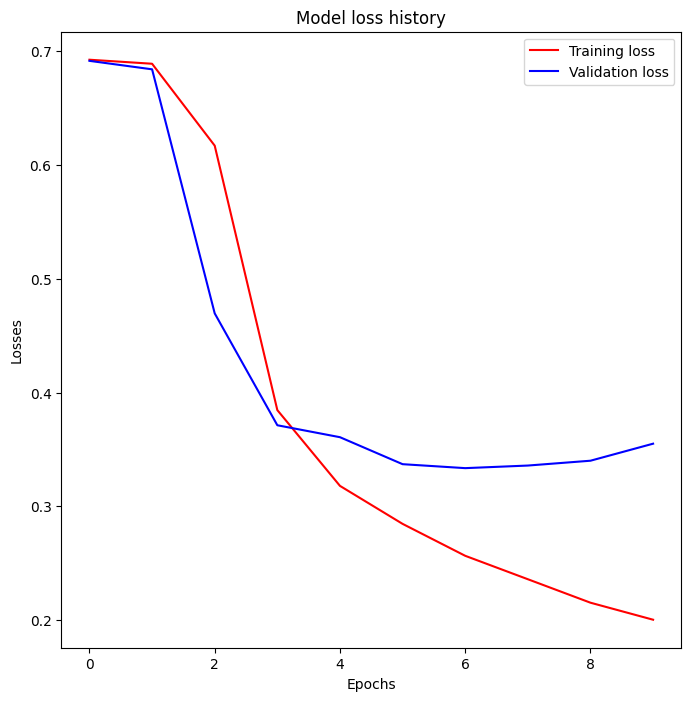

In [19]:
# Training results
fig = plt.figure(figsize=(8,8))
plt.plot(model.history.history['loss'], 'r', label='Training loss')
plt.plot(model.history.history['val_loss'], 'b', label='Validation loss')
plt.title('Model loss history')
plt.ylabel('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

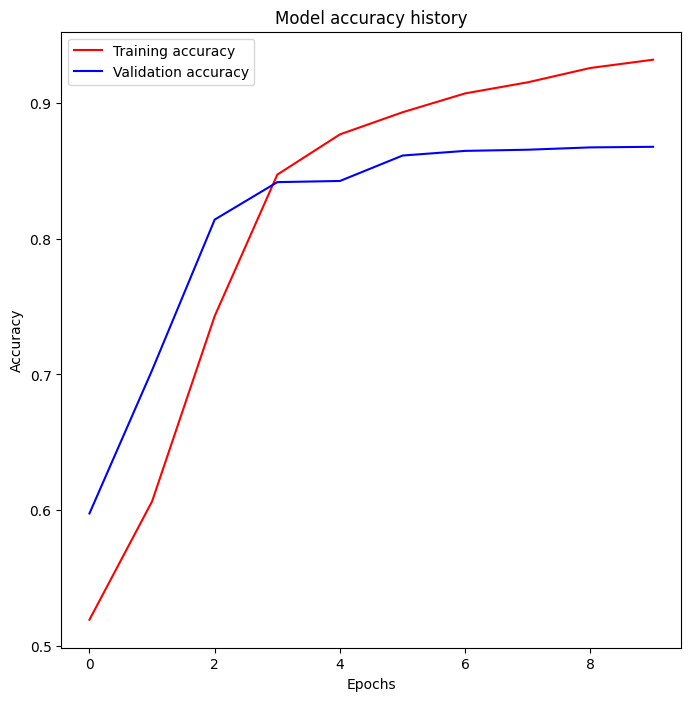

In [20]:
# Training results
fig = plt.figure(figsize=(8,8))
plt.plot(model.history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(model.history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Model accuracy history')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Testing the model

In [21]:
test_df = pd.read_csv('/content/testData.tsv', header=0, delimiter="\t", quoting=3)
test_df.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [22]:
# apply cleaning on test
test_df["review"] = test_df.review.apply(lambda x: clean_text(x))

# extract and binarize id data as sentiment
test_df["sentiment"] = test_df["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

y_test = test_df["sentiment"] # label

# tokenize, convert to numbers
list_sentences_test = test_df["review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [23]:
# Predict on test set
prediction = model.predict(X_te)

y_pred = (prediction > 0.5)

782/782 [==============================] - 27s 33ms/step


### Model Evaluation

In [24]:
print('Confusion matrix:')

confusion_matrix(y_pred, y_test)

Confusion matrix:


array([[11051,  2040],
       [ 1449, 10460]])

In [25]:
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))

F1-score: 0.8570609201524028
